In [15]:
from kdap.converter.wikiConverter import wikiConverter
from datetime import date
import xmltodict
import datetime
import mwparserfromhell
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from prettytable import PrettyTable

In [16]:
article = 'Indian Institute of Information Technology Una'
wikiConverter.getArticle(file_name = article, output_dir = 'wiki')

Indian Institute of Information Technology Una Completed!


In [17]:
class wikiStats :
    
    #GENERAL STATISTICS
    def __init__(self, article) :
        
        f = open("botList.txt",'r')
        self.bots = [ x.rstrip('\n') for x in list(f.readlines())]
        
        self.di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
        self.revisions = [x for x in self.di['mediawiki']['page']['revision']] 
        
        self.editors = {}
        self.botEditors = {}
        self.originals = {}
        
        for x in self.revisions :
            if x['sha1'] not in self.originals :
                self.originals[x['sha1']] = x['timestamp']
            username = x['contributor']['username'] if 'username' in x['contributor'] else x['contributor']['ip']
            if username not in self.bots:
                if username in self.editors :
                    self.editors[username] += 1
                else :
                    self.editors[username] = 1
            else :
                if username in self.botEditors :
                    self.botEditors[username] += 1
                else :
                    self.botEditors[username] = 1 
    
    def isOriginalRevision(self, revision) :
        return True if self.originals[revision['sha1']] == revision['timestamp'] else False
    
    def getID(self) :
        return self.di['mediawiki']['page']['id']
            
    def getRevertedEdits(self) :
        i = 0
        for x in self.revisions :
            if not self.isOriginalRevision(x) :
                i += 1
        return i
    
    def getTotalEdits(self) :
        return len(self.revisions) 
    
    def getMinorEdits(self) :
        i = 0
        for x in self.revisions :
            if 'minor' in x :
                i += 1
        return i
    
    def getIPEdits(self) :
        i = 0
        for x in self.revisions :
            if 'ip' in x['contributor'] :
                i += 1
        return i
    
    def getBotEdits(self) :
        ans = 0
        for bot in self.botEditors.keys() :
            ans += self.botEditors[bot]
        return ans
    
    def getEditors(self) :
        return len(self.editors) + len(self.botEditors)
    
    def getPageSize(self) :
        return self.revisions[-1]['text']['@bytes']
    
    def getFirstEdit(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getLatestEdit(self) :
        di = {}
        di['user'] = self.revisions[-1]['contributor']['username'] if 'username' in self.revisions[-1]['contributor'] else self.revisions[-1]['contributor']['ip']
        di['time'] = self.revisions[-1]['timestamp']
        try :
            di['text added'] = int(self.revisions[-1]['text']['@bytes']) - int(self.revisions[-2]['text']['@bytes'])
        except :
            di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getMaxTextAdded(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = int(self.revisions[0]['text']['@bytes'])
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if self.isOriginalRevision(self.revisions[i]) and temp > di['text added'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text added'] = temp
        return di
    
    def getMaxTextDeleted(self) :
        di = {}
        di['user'] = None
        di['time'] = None
        di['text deleted'] = 0
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if temp < di['text deleted'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text deleted'] = temp
        return di
    
    #EDITS 
    def getAverageEditsPerUser(self) :
        return self.getTotalEdits()/self.getEditors()
    
    def getAverageTimeBetweenEdits(self) :
        timestamps = [ self.di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(self.di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        timeDiff = date(1, 1, 1) - date(1, 1, 1)
        for i in range(len(times)-1) :
            timeDiff += times[i+1] - times[i]
        return timeDiff.days/(len(times)-1)
    
    def getAverageEditsPerDay(self) :
        t1 = self.getFirstEdit()['time']
        t1 = date(year = int(t1[:4]), month = int(t1[5:7]), day = int(t1[8:10]))
        t2 = datetime.date.today()
        return self.getTotalEdits()/(t2-t1).days
    
    def getAverageEditsPerMonth(self) :
        return 30*self.getAverageEditsPerDay()
    
    def getAverageEditsPerYear(self) :
        return 365*self.getAverageEditsPerDay()
    
    def getEditsInPastXDays(self, x) :
        timestamps = [ self.di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(self.di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        t0 = datetime.date.today()
        count = 0
        for i in range(len(times)-1, -1, -1) :
            t = times[i]
            tDiff = t0 - t
            if tDiff.days > x :
                break
            else :
                count += 1
        return count
        
    def getEditsInPast24Hours(self) :
        return self.getEditsInPastXDays(x = 1)
    
    def getEditsInPast7Days(self) :
        return self.getEditsInPastXDays(x = 7)
        
    def getEditsInPast30Days(self) :
        return self.getEditsInPastXDays(x = 30)
    
    def getEditsInPast365Days(self) :
        return self.getEditsInPastXDays(x = 365)
    
    def getEditsByTop10Editors(self) :
        arr = []
        for x in self.editors.keys() :
            arr.append(self.editors[x])
        arr.sort(reverse = True)
        top10Edits = 0
        for i in range(10) :
            try :
                top10Edits += arr[i]
            except :
                break
        return top10Edits
    
    def printGeneralStats(self) :
        print("              ID :", self.getID())
        print("       Page Size :", self.getPageSize())
        print("     Total Edits :", self.getTotalEdits())
        print("         Editors :", self.getEditors())
        print()
        print(" ----------------------------------- ")
        print()
        print("     Minor Edits :", self.getMinorEdits())
        print("        IP Edits :", self.getIPEdits())
        print("       Bot Edits :", self.getBotEdits())
        print("  Reverted Edits :", self.getRevertedEdits())
        print()
        print("      First Edit :", self.getFirstEdit())
        print("     Latest Edit :", self.getLatestEdit())
        print("  Max Text Added :", self.getMaxTextAdded())
        print("Max Text Deleted :", self.getMaxTextDeleted())
        print()
        print(" ----------------------------------- ")
        print()
        print("   Average Time Between Edits (days) :", self.getAverageTimeBetweenEdits(),"days")
        print("              Average Edits Per User :", self.getAverageEditsPerUser())
        print("               Average Edits Per Day :", self.getAverageEditsPerDay())
        print("             Average Edits Per Month :", self.getAverageEditsPerMonth())
        print("              Average Edits Per Year :", self.getAverageEditsPerYear())
        print()
        print("          Edits In The Past 24 Hours :", self.getEditsInPast24Hours())
        print("            Edits In The Past 7 Days :", self.getEditsInPast7Days())
        print("           Edits In The Past 30 Days :", self.getEditsInPast30Days())
        print("          Edits In The Past 365 Days :", self.getEditsInPast365Days())
        print()
        print("Edits Made By The Top 10% Of Editors :", self.getEditsByTop10Editors())
        print()
        print(" ----------------------------------- ")
    
    #charts
    def getMajorMinorGraph(self) :
        labels = ["Major edits","Minor Edits"]
        values = [self.getTotalEdits() - self.getMinorEdits(), self.getMinorEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/self.getTotalEdits()) + "%)"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def getAccountIPGraph(self) :
        labels = ["Accounts","IPs"]
        values = [self.getTotalEdits() - self.getIPEdits(), self.getIPEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/self.getTotalEdits()) + "%)"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
        
    def getTop10Bottom90Graph(self) :
        labels = ["Top 10% ","Bottom 90%"]
        values = [self.getEditsByTop10Editors(), self.getTotalEdits() - self.getEditsByTop10Editors()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])+ " (" + "{0:.1f}".format(100*values[i]/self.getTotalEdits()) + "%)"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def modifyEditors(self) :
        editorsArray = []
        for x in self.editors.keys() :
            di ={}
            di["username"] = x
            di["total edits"] = 0
            di["minor edits"] = 0
            di["first edit"] = None
            di["latest edit"] = None
            di["bytes added"] = 0
            editorsArray.append(di)
        
        for i in range(len(self.revisions)) :
            x = self.revisions[i]
            username = x['contributor']['username'] if 'username' in x['contributor'] else x['contributor']['ip']
            for editor in editorsArray :
                if editor["username"] == username :
                    editor["total edits"] += 1
                    editor["minor edits"] += 1 if 'minor' in x else 0
                    if editor["first edit"] == None :
                        editor["first edit"] = x['timestamp'][:-1].replace('T', ' ')
                        
                    editor["latest edit"] = x['timestamp'][:-1].replace('T', ' ')
                    if i != 0 and self.isOriginalRevision(x):
                        editor["bytes added"] += max(0, int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes']))
                    if i == 0 :
                        editor["bytes added"] += int(x['text']['@bytes'])
        editorsArray.sort(key = lambda x: x["first edit"], reverse = True)
        editorsArray.sort(key = lambda x: x["minor edits"], reverse = True)
        editorsArray.sort(key = lambda x: x["total edits"], reverse = True)
        return editorsArray
    
    def getTop10ByEditsGraph(self) :
        editors = self.modifyEditors()
        editors.sort(key = lambda x: x["total edits"], reverse = True)
        
        labels = [editors[i]["username"] for i in range(min(10, len(editors))) ]
        values = [editors[i]["total edits"] for i in range(len(labels))]
        colors = [ '#abd4eb', "#b2df8a", '#fb9a99', '#f3bf6f', '#cab2d6', '#cfb680', '#8dd3c7', '#fccde5', '#fff7a1', '#fc9272' ]
        explode = [0.01 for i in range(len(labels)) ]
        
        total = 0
        for value in values :
            total += value
            
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/total) + "%)"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, radius = 1.5, colors = colors, explode = explode, startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
        
    def getTop10ByAddedTextGraph(self) :
        editors = self.modifyEditors()
        editors.sort(key = lambda x: x["bytes added"], reverse = True)
        
        labels = [editors[i]["username"] for i in range(min(10, len(editors))) ]
        values = [editors[i]["bytes added"] for i in range(len(labels))]
        colors = [ '#abd4eb', "#b2df8a", '#fb9a99', '#f3bf6f', '#cab2d6', '#cfb680', '#8dd3c7', '#fccde5', '#fff7a1', '#fc9272' ]
        explode = [0.01 for i in range(len(labels)) ]
        plt.pie(values, radius = 1.5, colors = colors, explode = explode, startangle=90, counterclock = False)
 
        total = 0
        for value in values :
            total += value
             
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/total) + "%)"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def printTopEditors(self, count = 10) :
        editors = self.modifyEditors()[:count]
        t = PrettyTable(["Username", "Edits", "MinorEdits", "MinorEdits%", "First Edit", "Latest Edit", "Added(bytes)"])
        for x in editors :
            t.add_row([ x["username"], x["total edits"], x["minor edits"], "{0:.1f}".format(100*x["minor edits"]/x["total edits"]) + "%", x["first edit"], x["latest edit"], x["bytes added"]] )
        print(t)

In [18]:
stats = wikiStats(article)

In [19]:
stats.printTopEditors()

+--------------------+-------+------------+-------------+---------------------+---------------------+--------------+
|      Username      | Edits | MinorEdits | MinorEdits% |      First Edit     |     Latest Edit     | Added(bytes) |
+--------------------+-------+------------+-------------+---------------------+---------------------+--------------+
|       Shahvr       |   16  |     0      |     0.0%    | 2016-01-30 11:04:48 | 2016-01-30 12:05:46 |     3873     |
|      Pra8eek       |   2   |     2      |    100.0%   | 2019-05-20 09:00:20 | 2019-05-21 05:26:11 |      85      |
|  Shivamtripathi21  |   2   |     1      |    50.0%    | 2016-07-01 09:10:43 | 2016-07-01 09:18:35 |     826      |
|      Muhandes      |   2   |     0      |     0.0%    | 2017-08-29 14:08:37 | 2017-12-05 10:42:16 |      11      |
|    59.144.74.2     |   2   |     0      |     0.0%    | 2017-08-01 05:06:08 | 2017-08-01 05:06:24 |      1       |
| Nocowardsoulismine |   2   |     0      |     0.0%    | 2016-0

In [20]:
stats.printGeneralStats()

              ID : 49267508
       Page Size : 5347
     Total Edits : 47
         Editors : 26

 ----------------------------------- 

     Minor Edits : 9
        IP Edits : 7
       Bot Edits : 5
  Reverted Edits : 2

      First Edit : {'user': 'Shahvr', 'time': '2016-01-30T11:04:48Z', 'text added': '1261'}
     Latest Edit : {'user': 'Pra8eek', 'time': '2019-05-21T05:26:11Z', 'text added': 3}
  Max Text Added : {'user': 'Shahvr', 'time': '2016-01-30T11:04:48Z', 'text added': 1261}
Max Text Deleted : {'user': 'Shahvr', 'time': '2016-01-30T11:51:36Z', 'text deleted': -645}

 ----------------------------------- 

   Average Time Between Edits (days) : 26.23913043478261 days
              Average Edits Per User : 1.8076923076923077
               Average Edits Per Day : 0.03775100401606426
             Average Edits Per Month : 1.1325301204819278
              Average Edits Per Year : 13.779116465863455

          Edits In The Past 24 Hours : 0
            Edits In The Past 7 Days : 0

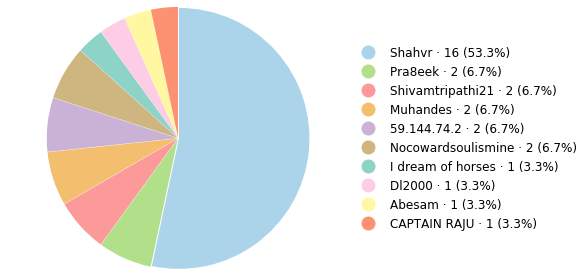

In [22]:
stats.getTop10ByEditsGraph()

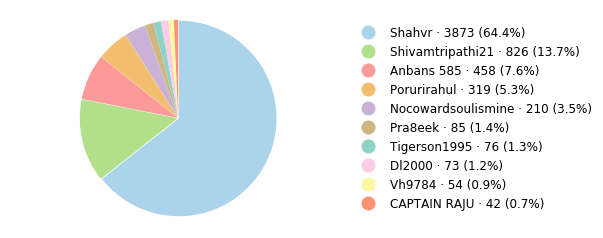

In [23]:
stats.getTop10ByAddedTextGraph()

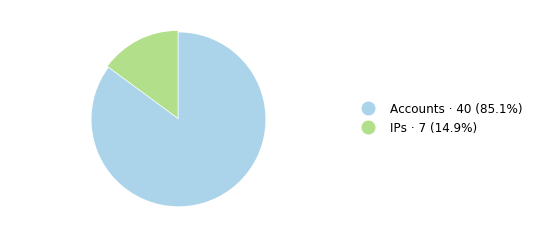

In [24]:
stats.getAccountIPGraph()

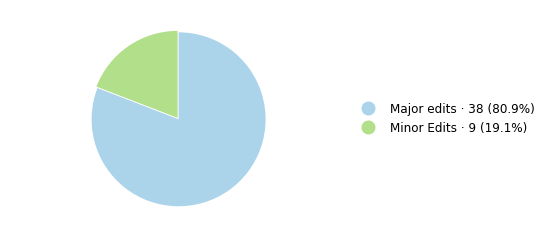

In [25]:
stats.getMajorMinorGraph()

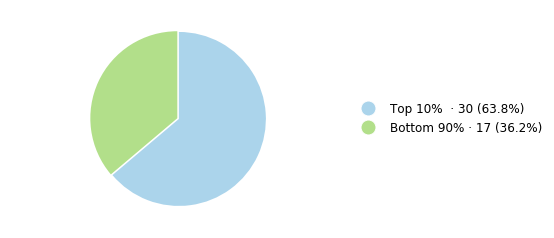

In [26]:
stats.getTop10Bottom90Graph()